In [10]:
%%javascript

window.scroll_flag = true
window.scroll_exit = false
window.scroll_delay = 100

$(".output_scroll").each(function() {
    $(this)[0].scrollTop = $(this)[0].scrollHeight;
});

function callScrollToBottom() {
    setTimeout(scrollToBottom, window.scroll_delay);
}

function scrollToBottom() {
    if (window.scroll_exit) {
        return;
    }
    if (!window.scroll_flag) {
        callScrollToBottom();
        return;
    };
    
    $(".output_scroll").each(function() {
        if (!$(this).attr('scroll_checkbox')){
            window.scroll_flag = true;
            $(this).attr('scroll_checkbox',true);
            var div = document.createElement('div');
            var checkbox = document.createElement('input');
            checkbox.type = "checkbox";
            checkbox.onclick = function(){window.scroll_flag = checkbox.checked}
            checkbox.checked = "checked"
            div.append("Auto-Scroll-To-Bottom: ");
            div.append(checkbox);
            $(this).parent().before(div);
        }
        
        $(this)[0].scrollTop = $(this)[0].scrollHeight;
    });
    callScrollToBottom();
}
scrollToBottom();

<IPython.core.display.Javascript object>

In [11]:
import time
from pathlib import Path
import glob
import os
import numpy as np
from tqdm import tqdm
import itertools
import csv
import matplotlib.pyplot as plt
from scipy.io import wavfile
import librosa
import IPython.display as ipd
from IPython.display import clear_output
import math

import torch
import torchaudio
import soundfile as sf
from torchaudio.transforms import Vad

import wave
import librosa
import contextlib

from utils import *
import random
import shutil
from tqdm import tqdm
import subprocess
from pydub import AudioSegment

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('grid', linestyle="-", color='black')

## Audio utils

In [13]:
def plot_spec(filepath):
    samplingFrequency, signalData = wavfile.read(filepath)
    
    # Plot the signal read from wav file
    if len(signalData.shape) == 1:
        # single channel
        plt.figure(figsize=(12,8))
#         plt.grid(visible=True, axis='both')
        plt.subplot(211)

        plt.title('Spectrogram of a wav file')

        plt.plot(signalData)
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')

        plt.subplot(212)
        plt.specgram(signalData,Fs=samplingFrequency,NFFT=512)
        plt.xlabel('Time')
        plt.ylabel('Frequency')
    else:
        signal_transpose = signalData.T
        for i, signal in enumerate(signal_transpose):
            print(f"Channel {i + 1}")
            plt.figure()
            plt.subplot(211)
            plt.title('Spectrogram of a wav file')

            plt.plot(signal.T)
            plt.xlabel('Sample')
            plt.ylabel('Amplitude')

            plt.subplot(212)
            plt.specgram(signal.T,Fs=samplingFrequency,NFFT=512)
            plt.xlabel('Time')
            plt.ylabel('Frequency')

    plt.show()
    
def plot_duo(path1, path2):
    samplingFrequency1, signalData1 = wavfile.read(path1)
    samplingFrequency2, signalData2 = wavfile.read(path2)
    # single channel
#     plt.figure(figsize=(20,8))
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 4))
    axs[0, 0].plot(signalData1)
    axs[0, 0].set_title('Ref')
    axs[0, 0].set(xlabel='Sample', ylabel='Amplitude')
    
    axs[0, 1].specgram(signalData1,Fs=samplingFrequency1,NFFT=512)
    axs[0, 1].set(xlabel='Time', ylabel='Frequency')
    

    axs[1, 0].plot(signalData2)
    axs[1, 0].set_title('Com')
    axs[1, 0].set(xlabel='Sample', ylabel='Amplitude')
    
    axs[1, 1].specgram(signalData2,Fs=samplingFrequency2,NFFT=512)
    axs[1, 1].set(xlabel='Time', ylabel='Frequency')
    
    plt.tight_layout()
    plt.show()

def get_duration_file(fn_audio):
    with contextlib.closing(wave.open(str(fn_audio),'r')) as f:
        frames = f.getnframes()
        rate = f.getframerate()
        duration = frames / float(rate)
    return duration

def get_audio_overview(fn_audio):
    ob =  sf.SoundFile(fn_audio)
    return ob.subtype, ob.samplerate, ob.channels


def get_amplitute_file(path):
    sr, data = wavfile.read(path)
#     bit_depth = int(get_infor_file(path)[0].split('_')[-1])
    bit_depth = 16
    db = 20 * np.log10(max(abs(data))/(2**(bit_depth - 1) - 1))
    return sr, min(data), max(data), db

def get_duration_folder(folder):
    total_length = 0
    for audio in glob.glob(f"{folder}/*.wav"):
        try:
            total_length += get_duration_file(audio)
        except:
            print("error in ",audio)
    return total_length

def get_size_file(fname):
    return Path(fname).stat().st_size

def get_size_folder(folder):
    return sum([float(get_size_file(f)) for f in glob.glob(f"{folder}/*")])

def get_audio_stats(filename):
    cmd = ['ffmpeg', '-i', filename, '-map', '0:a', '-af', 'astats', '-f', 'null', '-']
#     cmd = ['ffprobe', filename]
    out = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE).stderr
    output_lines = [line.strip() for line in out.decode('utf-8').split('\n')]
    return output_lines


In [14]:
def stream_and_plot_audio(path, plot=False):
    audio = ipd.Audio(path, autoplay=True) 
    ipd.display(audio)
    if plot:
        plot_spec(path)

def stream_and_plot_in_class(folder, plot=False):
    audio_in_folder = glob.glob(f'{folder}/*.wav')
    for i, f in enumerate(audio_in_folder):
        path  = str(Path(f))
        print(f"[{i + 1}/{len(audio_in_folder)}] {path}", end=' ')

        stream_and_plot_audio(path, plot=plot)

        duration = librosa.get_duration(filename=path)
        # print(duration, end='\n\n')
        time.sleep(duration + 0.25)
        stream_and_plot_audio("dataset/Blink.mp3", plot=plot)
        time.sleep(duration + 0.5)

        
def stream_and_plot_in_root(folders, plot=False):
    nfiles = [len(os.listdir(x)) for x in folders]
    start_id = 0

    for index, folder in enumerate(folders):
        print(folders[index], 'id:', index, 'count:', sum(nfiles[:index]))
        
        stream_and_plot_in_class(folder, plot=plot)
        time.sleep(1.0)
        clear_output(wait=True)
        
def compare2files(file1, file2, plot=False, stream=False):
    if plot:
        plot_duo(file1, file2)
        
    if stream:
        stream_and_plot_audio(file1, plot=False)
        duration = librosa.get_duration(filename=file1)
        time.sleep(duration + 0.5)

        stream_and_plot_audio(file2, plot=False)
        duration = librosa.get_duration(filename=file2)
        time.sleep(duration + 0.5)

In [15]:
import noisereduce as nr
# load data
def remove_noise(path):
    rate, data = wavfile.read(path)
    # perform noise reduction
    reduced_noise = nr.reduce_noise(y=data, sr=rate, n_fft=512, prop_decrease=0.99)
    filename = f"{path.replace('.wav', '')}_rm_noise.wav"
    wavfile.write(filename, rate, reduced_noise)
    return True

def convert_audio(audio_path, new_format='wav', freq=8000, out_path=None):
    """Convert audio format and samplerate to target"""
    try:
        org_format = audio_path.split('.')[-1].strip()
        if new_format != org_format:
            audio = AudioSegment.from_file(audio_path)
            # export file as new format
            audio_path = audio_path.replace(org_format, new_format)
            audio.export(audio_path, format=new_format)
    except Exception as e:
        raise e
        
    try:
        sound = AudioSegment.from_file(audio_path, format='wav')
        sound = sound.set_frame_rate(freq)
        sound = sound.set_channels(1)
        
        if out_path is not None:
            out_path = audio_path
        sound.export(audio_path, format='wav')
    except Exception as e:
        raise e
        
    return audio_path

def change_volume(path=None, dB=6, overwrite=True):
    segment = AudioSegment.from_file(path)
    segment += dB
    if overwrite:
        path = path
    else:
        path = path.replace('.wav', '') + f'_{dB}' +'.wav'
    segment.export(path, format='wav')
    print(f'Export to {path}')

In [16]:
def read_blacklist(id, duration_limit=1.0, 
                   dB_limit=-16, 
                   error_limit=None, 
                   noise_limit=-15, 
                   details_dir="dataset/train_details_full/"):
    '''
    header = ['File name', 'Duration', 'Size(MB)', 'Min level', 'Max level', 
              'Min difference', 'Max difference', 'Mean difference', 'RMS difference', 
              'Peak level dB', 'RMS level dB',   'RMS peak dB', 'RMS trough dB', 
              'Crest factor', 'Flat factor', 'Peak count',
              'Noise floor dB', 'Noise floor count', 'Bit depth', 'Dynamic range', 
              'Zero crossings', 'Zero crossings rate', 'Error rate', 'Full path']
    '''
    blacklist = []
    readfile = str(Path(details_dir, f"{id}.csv"))
    if not error_limit:
        # auto choose
        error_limit = 0.5
        
    if os.path.exists(readfile):
        with open(readfile, 'r', newline='') as rf:
            spamreader = csv.reader(rf, delimiter=',')
            next(spamreader, None)
            for row in spamreader:
                short_length = (float(row[1]) < duration_limit)
                low_amplitude = (float(row[9]) < dB_limit)
                high_err = (float(row[-2]) > error_limit)
                high_noise = (float(row[16]) > noise_limit)
                if short_length or low_amplitude or high_err or high_noise:
                    blacklist.append(Path(row[-1]))
        return list(set(blacklist))
    else:
        return None

def get_audio_properties(fname):
    with contextlib.closing(wave.open(fname,'r')) as f:
        frames = f.getnframes()
        rate = f.getframerate()
        duration = frames / float(rate)
        return duration, rate
    
    
def check_valid_audio(files, duration_lim=1.5, sr=8000):
    filtered_list = []
    files = [str(path) for path in files]
    
    for fname in files:
        duration, rate = get_audio_properties(fname)
        if rate == sr and duration >= duration_lim:
            filtered_list.append(fname)
        else:
            pass
    filtered_list.sort(reverse=True, key = lambda x: get_audio_properties(x)[0])    
    filtered_list = [Path(path) for path in filtered_list]
    return filtered_list

## Stream and visualize audio


#### File

/opt/conda/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7702: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


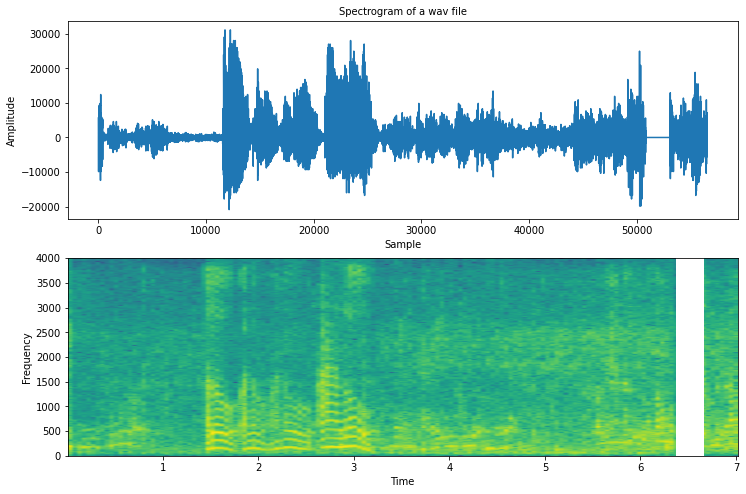

In [75]:
path = f"log_service/audio/20220208_101958_com.wav"
stream_and_plot_audio(path, plot=True)
# !ffprobe "dataset/spoof/2835449000/2835449000_23_zoneB_rm_noise.wav"

/opt/conda/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7702: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


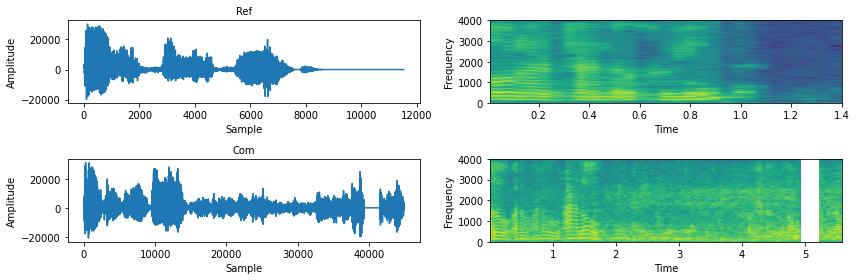

In [78]:
com = f"log_service/audio/20220208_101958_com_vad_1.wav"

ref = f"log_service/audio/20220208_101947_ref_vad_0.wav"

compare2files(ref, com, plot=True, stream=True)

#### Class

In [9]:
stream_and_plot_in_class("dataset/train_callbot/train/342572370/", plot=False)

[1/10] dataset/train_callbot/train/342572370/342572370-20211229-120421-in_0.wav 

[2/10] dataset/train_callbot/train/342572370/342572370-20211230-205413-in_0.wav 

[3/10] dataset/train_callbot/train/342572370/342572370-20211230-205413-in_1.wav 

[4/10] dataset/train_callbot/train/342572370/342572370-20211230-205413-in_2.wav 

[5/10] dataset/train_callbot/train/342572370/342572370-20211230-205413-in_3.wav 

[6/10] dataset/train_callbot/train/342572370/342572370-20211230-205413-in_4.wav 

[7/10] dataset/train_callbot/train/342572370/342572370-20211230-205413-in_5.wav 

[8/10] dataset/train_callbot/train/342572370/342572370-20211230-205312-in_0.wav 

[9/10] dataset/train_callbot/train/342572370/342572370-20211230-205312-in_1.wav 

[10/10] dataset/train_callbot/train/342572370/342572370-20211230-205312-in_2.wav 

#### stats of audio

In [ ]:
!ffmpeg -i "dataset/spoof/2835449000/2835449000_23_zoneC.wav" -map 0:a -af astats -f null -

In [210]:
get_audio_stats('dataset/dump/366524143-20211229-084350_1.wav'), get_audio_stats('dataset/dump/366524143-20211229-084350_1_vad_0.wav') 

(['ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers',
  'built with gcc 9 (Ubuntu 9.3.0-17ubuntu1~20.04)',
  'configuration:',
  'libavutil      56. 51.100 / 56. 51.100',
  'libavcodec     58. 91.100 / 58. 91.100',
  'libavformat    58. 45.100 / 58. 45.100',
  'libavdevice    58. 10.100 / 58. 10.100',
  'libavfilter     7. 85.100 /  7. 85.100',
  'libswscale      5.  7.100 /  5.  7.100',
  'libswresample   3.  7.100 /  3.  7.100',
  'Guessed Channel Layout for Input Stream #0.0 : mono',
  "Input #0, wav, from 'dataset/dump/366524143-20211229-084350_1.wav':",
  'Duration: 00:00:06.09, bitrate: 128 kb/s',
  'Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 8000 Hz, mono, s16, 128 kb/s',
  'Stream mapping:',
  'Stream #0:0 -> #0:0 (pcm_s16le (native) -> pcm_s16le (native))',
  'Press [q] to stop, [?] for help',
  "Output #0, null, to 'pipe:':",
  'Metadata:',
  'encoder         : Lavf58.45.100',
  'Stream #0:0: Audio: pcm_s16le, 8000 Hz, mono, s16, 128 kb/s',
  'Me

## Perform vad on long file(>10s of duration)

In [73]:
path = f"log_service/audio/20220208_101947_ref.wav"
write = False
segments = VAD(win_length=300, frame_duration=30).detect(path, write=write, show=True)
print(len(segments))

111_____________________1111111____1111111111+(1.0500000000000007)1111111111111111111111111111__________-(2.4899999999999984)_________________111___________111__
1


# Visualize by graph dataset, plot graph

In [ ]:
origin = "dataset/train_callbot/train"
filenames = glob.glob(f"{origin}/*")

### number of files

In [ ]:
# so luong files moi nguoi
no_of_files = []
for f in tqdm(filenames):
    if len(os.listdir(f)) == 0:
        print(f)
    no_of_files.append(len(os.listdir(f)))
plt.figure(figsize=(24, 8))
plt.bar(filenames, no_of_files), plt.ylabel('number of files'), plt.xticks([])
plt.tight_layout()

In [ ]:
filenames[np.argmax(no_of_files)], filenames[np.argmin(no_of_files)], sum(no_of_files), max(no_of_files), min(no_of_files)

### Duration

In [ ]:
# duration
durations = []
for fn in tqdm(filenames):
    length = get_duration_folder(fn)
    durations.append(length)
plt.figure(figsize=(24, 8))
plt.bar(filenames, durations), plt.ylabel('durations'), plt.xticks([]), plt.tight_layout()
plt.show()

In [ ]:
np.mean(durations), np.argmax(durations), sum(durations), max(durations), min(durations)

### average duration 

In [ ]:
# mat do thoi gian / 1 audio tren moi nguoi
import numpy as np
no_of_files = np.array(no_of_files)
durations = np.array(durations)
avg_durations = np.divide(durations, no_of_files)
plt.figure(figsize=(24, 8))
plt.bar(filenames, avg_durations), plt.ylabel('avg_durations'), plt.xticks([]), plt.tight_layout()
plt.show()

In [ ]:
avg_durations.mean(), np.argmax(avg_durations), max(avg_durations), min(avg_durations)

In [ ]:
len(avg_durations[(avg_durations >= 1.5).nonzero()])

In [10]:
#  index: 0'Duration', 1'Size(MB)', 2'Min level', 3'Max level', 
#         4'Min difference', 5'Max difference', 6'Mean difference', 7'RMS difference', 
#         8'Peak level dB', 9'RMS level dB', 10'RMS peak dB', 11'RMS trough dB', 
#         12'Crest factor', 13'Flat factor', 14'Peak count',
#         15'Noise floor dB', 16'Noise floor count', 17'Dynamic range', 
#         18'Zero crossings', 19'Zero crossings rate', 20'Error rate',

audio_full_infor = {}
detail_dir = Path('dataset/train_callbot/details/')
csv_s = detail_dir.glob('*.csv')

for f in tqdm(csv_s):
    audio_full_infor[f.name.replace('.csv', '')] = []
    
    with open(f, 'r', newline='') as rf:
        spamreader = csv.reader(rf, delimiter=',')
        next(spamreader, None)
        for row in spamreader:
            row_n = []
            for e in row:
                try:
                    row_n.append(float(e.strip()))
                except:
                    pass
            audio_full_infor[f.name.replace('.csv', '')].append(np.asanyarray(row_n))
            
    audio_full_infor[f.name.replace('.csv', '')] = np.asanyarray(audio_full_infor[f.name.replace('.csv', '')])
            
list(audio_full_infor.items())[:10]

14895it [00:05, 2530.97it/s]


[('326359800',
  array([[ 2.299875e+00,  3.684200e+04, -2.655300e+04, ...,  3.143000e+03,
           1.708250e-01,  0.000000e+00],
         [ 1.860125e+00,  2.980600e+04, -2.751600e+04, ...,  2.384000e+03,
           1.602040e-01,  0.000000e+00],
         [ 1.300125e+00,  2.084600e+04, -1.236000e+04, ...,  1.647000e+03,
           1.583500e-01,  0.000000e+00],
         ...,
         [ 2.040000e+00,  3.268400e+04, -2.821800e+04, ...,  2.791000e+03,
           1.710170e-01,  0.000000e+00],
         [ 1.300000e+00,  2.084400e+04, -6.282000e+03, ...,  1.863000e+03,
           1.791350e-01,  0.000000e+00],
         [ 1.050000e+00,  1.684400e+04, -2.487300e+04, ...,  1.304000e+03,
           1.552380e-01,  0.000000e+00]])),
 ('376364264',
  array([[ 3.24000000e+00,  5.18840000e+04, -1.93950000e+04,
           2.30400000e+04,  0.00000000e+00,  2.12430000e+04,
           9.66427177e+02,  1.79043921e+03, -3.05908400e+00,
          -2.14066820e+01, -1.48664480e+01, -3.56184150e+01,
           8.

index: <br/>
0'Duration', 1'Size(MB)', 2'Min level', 3'Max level', <br/>
4'Min difference', 5'Max difference', 6'Mean difference', 7'RMS difference', <br/>
8'Peak level dB', 9'RMS level dB', 10'RMS peak dB', 11'RMS trough dB', <br/>
12'Crest factor', 13'Flat factor', 14'Peak count', <br/>
15'Noise floor dB', 16'Noise floor count', 17'Dynamic range', <br/>
18'Zero crossings', 19'Zero crossings rate', 20'Error rate', <br/>

In [185]:
categories = ['Avg_duration', 'Min_duration', 'Max_duration', 
              'Avg_peakdB', 'Min_peakdB', 'Max_peakdB',
              'Avg_noisedB', 'Min_noisedB', 'Max_noisedB',
              '#valid files', '%valid']

# writefile = 'dataset/details_callbot.csv'
with open(writefile, 'w', newline='') as wf:
    spamwriter = csv.writer(wf, delimiter=',')
    spamwriter.writerow(categories)
    
    for k, v in tqdm(audio_full_infor.items()):
        avg_dur, min_dur, max_dur = np.mean(v[:,0]), min(v[:,0]), max(v[:,0])
        avg_db, min_db, max_db = np.mean(v[:,8]), min(v[:,8]), max(v[:,8])
        avg_noisedb, min_noisedb, max_noisedb =  np.mean(v[:,15]), min(v[:,15]), max(v[:,15])
        # error rate add here#
        f_invalid = read_blacklist(id=k,
                                 duration_limit=1.0, 
                                 dB_limit=-16, 
                                 error_limit=0, 
                                 noise_limit=-10, 
                                 details_dir="dataset/train_callbot/details/" )
        n_valid = len(v) - len(f_invalid) if f_invalid else len(v)
        p_valid = n_valid / len(v)
        
        row =  [avg_dur, min_dur, max_dur,
               avg_db, min_db, max_db,
               avg_noisedb, min_noisedb, max_noisedb,
               n_valid, p_valid]
#         spamwriter.writerow(row)

100%|██████████| 14895/14895 [00:05<00:00, 2902.22it/s]


In [186]:
import pandas as pd
df = pd.read_csv('dataset/details_callbot.csv')
df

,Avg_duration,Min_duration,Max_duration,Avg_peakdB,Min_peakdB,Max_peakdB,Avg_noisedB,Min_noisedB,Max_noisedB,#valid files,%valid
0,1.647366,1.000125,3.499875,-2.688376,-11.359079,0.000265,-13.158149,-28.637886,-2.051338,34,0.641509
1,2.268420,1.020000,6.280125,-3.689866,-12.103718,-0.162143,-18.898805,-33.556170,-9.240222,24,0.960000
2,1.786661,1.000000,6.560000,-10.687744,-26.620584,-0.009814,-26.407013,-41.489757,-9.927275,13,0.619048
3,1.757121,1.000000,3.850000,-7.038054,-28.137433,-0.022561,-27.576051,-41.745242,-13.838454,24,0.857143
4,2.995507,1.060000,6.950000,-6.842637,-15.686633,-2.077686,-20.389637,-31.339679,-6.049279,14,0.777778
...,...,...,...,...,...,...,...,...,...,...,...
14890,3.318975,1.140000,6.100000,-8.637453,-12.870273,-2.937790,-28.099439,-46.445446,-17.558144,10,1.000000
14891,2.261437,1.220000,3.900000,-2.041294,-2.853070,-0.906995,-12.820327,-17.993145,-9.206491,11,0.785714
14892,1.253950,1.060000,1.620000,-8.158956,-22.879987,-2.424955,-17.459870,-27.870179,-12.677963,9,0.900000
14893,2.429012,1.260000,4.180000,-2.079759,-2.934816,-1.335844,-13.216907,-37.360279,-5.968794,7,0.700000


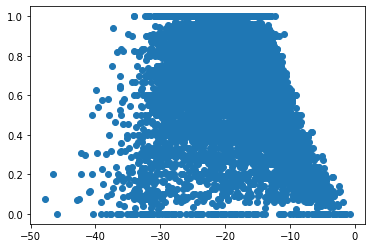

In [188]:
plt.scatter(df['Avg_noisedB'], df['%valid'])
plt.show()

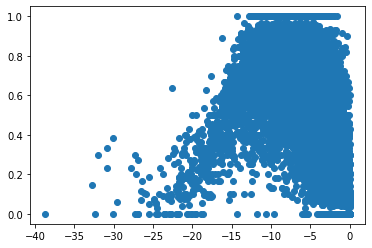

In [37]:
plt.scatter(df['Avg_peakdB'], df['%valid'])
plt.show()

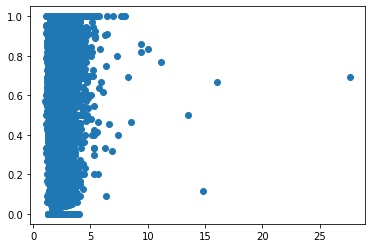

In [189]:
plt.scatter(df['Avg_duration'], df['%valid'])
plt.show()

In [190]:
a = df.loc[df['%valid'] <= 0.5]

b = df.loc[df['Avg_noisedB'] < -20]
# c = df.loc[-20 <= df['Avg_noisedB'] < -10]
# d = df.loc[-30 <= df['Avg_noisedB'] < -20]
# e = df.loc[df['Avg_noisedB'] < -30]
count = 0
for i in range(len(b)):
    if b.iloc[i]['%valid'] <= 0.5:
        count += 1
count / len(b)

0.15644073241246387

## Filtering DATASET

Check the inequality of dataset and print out details, return number of files greater ans lower than threshold(35 files)

In [398]:
with open("Imposter_v2.txt", 'r') as rf:
    lines = [line.strip().replace('\n', '') for line in rf.readlines()]

invalid_class = list(''.join(x.split(':')[1:]).strip() for x in filter(lambda x: True if ':' in x else False, lines))
invalid_files = list(''.join(x.split('-')[1:]).strip() for x in filter(lambda x: True if '-' in x else False, lines))
# len(invalid_files), len(invalid_class), invalid_class[-1], glob.glob("dataset/train/*").index(invalid_class[-1])

invalid_details = {}
for line in tqdm(lines):
    if ':' in line:
        k = ''.join(line.split(':')[1:]).strip()
        if k not in invalid_details:
            invalid_details[k] = {}
    elif '.wav' in line:
        fp = ''.join(line.split(' - ')[1:]).strip()
        n = line.split('-')[0].strip().replace('[', '').replace(']', '').split('/')
        rate = float(n[0])/float(n[1])
        
        k = list(invalid_details.keys())[-1]
        
        invalid_details[k][fp] = rate

list(invalid_details.items())[:10]
# invalid_cla                                                                                                                                     ss

100%|██████████| 1763975/1763975 [12:29<00:00, 2352.21it/s]


[('dataset/train/396650157',
  {'dataset/train/396650157/20210914155227-IOVSEQTG-309874_91402-10.61.85.10-vt_cskh_oksbich2789_cc1-379659439-50157-11789-396650157-CTM_0.wav': 0.01818181818181818,
   'dataset/train/396650157/20210914155227-IOVSEQTG-309874_91402-10.61.85.10-vt_cskh_oksbich2789_cc1-379659439-50157-11789-396650157-CTM_1.wav': 0.05454545454545454,
   'dataset/train/396650157/20210914155227-IOVSEQTG-309874_91402-10.61.85.10-vt_cskh_oksbich2789_cc1-379659439-50157-11789-396650157-CTM_10.wav': 0.01818181818181818,
   'dataset/train/396650157/20210914155227-IOVSEQTG-309874_91402-10.61.85.10-vt_cskh_oksbich2789_cc1-379659439-50157-11789-396650157-CTM_13.wav': 0.14545454545454545,
   'dataset/train/396650157/20210914155227-IOVSEQTG-309874_91402-10.61.85.10-vt_cskh_oksbich2789_cc1-379659439-50157-11789-396650157-CTM_14.wav': 0.05454545454545454,
   'dataset/train/396650157/20210914155227-IOVSEQTG-309874_91402-10.61.85.10-vt_cskh_oksbich2789_cc1-379659439-50157-11789-396650157-CTM_1

In [10]:
import itertools    
def all_pairs(lst):
    return list(itertools.combinations(lst, 2))

In [46]:
def generate_lists(raw_dataset, details_dir, num_spks, split_ratio,
                   duration_limit=1.0,
                   dB_limit=-10,
                   error_limit=0.5,
                   noise_limit=-16, 
                   lower_num=10, upper_num = 40):
    """
    Generate train test lists for zalo data
    """
    valid_spks = []
    invalid_spks = []
    
    root = Path(raw_dataset)
    classpaths = [d for d in root.iterdir() if d.is_dir()]
    classpaths.sort()
    
    if 0 < num_spks < len(classpaths) + 1:
        classpaths = classpaths[:num_spks]
    elif num_spks == -1:
        pass
    else:
        raise "Invalid number of speakers"

    print('Generate dataset metadata files, total:', len(classpaths))
    
    train_filepaths_list = []
    val_filepaths_list = []
    test_filepaths_list = []
    
    for classpath in tqdm(list(classpaths)[:], desc="Processing:..."):
        filepaths = list(classpath.glob('*.wav'))

        # check duration, volumn
        blist = read_blacklist(str(Path(classpath).name), 
                               duration_limit=duration_limit, 
                               dB_limit=dB_limit, 
                               error_limit=error_limit, 
                               noise_limit=noise_limit,
                               details_dir=details_dir)
#         print("blist", len(blist))
        if not blist:
            continue
#         print(len(filepaths))
        filepaths = list(set(filepaths).difference(set(blist)))
#         print(filepaths, blist)

        # check duration, sr
        filepaths = check_valid_audio(filepaths, 1.0, 8000)
#         print(len(filepaths))

        # checknumber of files
        if lower_num:
            if len(filepaths) < lower_num:
                invalid_spks.append([Path(classpath).name, len(filepaths)])
                continue
        if upper_num:
            if len(filepaths) >= upper_num:
                filepaths = filepaths[:upper_num]
                
        if len(filepaths) == 0:
            invalid_spks.append(Path(classpath).name)
            continue
                
        valid_spks.append(Path(classpath).name)

        random.shuffle(filepaths)
        train_filepaths = filepaths
        train_filepaths_list.extend(train_filepaths)

        
#         val
        val_num = 0  # 3 utterances per speaker for val

        if split_ratio > 0:
            val_num = int(split_ratio * len(filepaths))

        val_filepaths = random.sample(filepaths, val_num)

        val_filepaths_list.append(val_filepaths)
#         test
        test_filepaths_list.extend(filepaths) 
    
#     
#     val_writer = open(Path('dataset/test_callbot/valid_speaker/', 'public_test_cb.txt'), 'w')

    val_pairs = []
    for val_filepaths in val_filepaths_list:
        for i in range(len(val_filepaths) - 1):
            for j in range(i + 1, len(val_filepaths)):
                label = '1'
                positive_pair = label + ' ' + str(val_filepaths[i]) + ' ' + str(val_filepaths[j]) + '\n'
                val_pairs.append(positive_pair)
    
                label = '0'
                while True:
                    x = random.randint(0, len(val_filepaths_list) - 1)
                    if not val_filepaths_list[x]:
                        continue
                    if val_filepaths_list[x][0].parent.stem != val_filepaths[
                            i].parent.stem:
                        break
                y = random.randint(0, len(val_filepaths_list[x]) - 1)
                negative_pair = label + ' ' + str(val_filepaths[i]) + ' ' + str(val_filepaths_list[x][y]) + '\n'
                val_pairs.append(negative_pair)
    
#                 val_writer.write(positive_pair)
#                 val_writer.write(negative_pair)
                
#     val_writer.close()
        

    print("Valid speakers:", len(valid_spks))
    print("Valid audio files:", len(train_filepaths_list))
    print("Validation pairs:", len(val_pairs))
#     print("Test pairs:", len(all_pairs(test_filepaths_list)))

    return valid_spks, invalid_spks

In [47]:
valid_spks, invalid_spks = generate_lists(raw_dataset='dataset/train', 
                                          details_dir='dataset/details/train_cskh/', 
                                          num_spks=-1, split_ratio=-1, 
                                          duration_limit=1.0,
                                          dB_limit=-10,
                                          error_limit=0.5,
                                          noise_limit=-10,
                                          lower_num=10, upper_num = None)

Generate dataset metadata files, total: 44413


Processing:...: 100%|██████████| 44413/44413 [02:04<00:00, 356.60it/s]

Valid speakers: 44395
Valid audio files: 1039982
Validation pairs: 0


In [51]:
len(invalid_spks), invalid_spks[:]

(0, [])

In [33]:
for spk, nu in tqdm(invalid_spks[:]):
    path_dir = os.path.join("dataset/train/", spk)
    if os.path.exists(path_dir):
        subprocess.call(f"rm -rf {path_dir}", shell=True)
print("done")

done


In [33]:
os.makedirs('dataset/test_callbot/valid_speaker/public', exist_ok=True)

In [34]:
# private_test = random.sample(valid_spks, 100)
# private_test
for spk in tqdm(valid_spks):
    subprocess.call(f"cp -R {os.path.join('dataset/test_callbot/public', spk)} dataset/test_callbot/valid_speaker/public", shell=True)

100%|██████████| 392/392 [00:11<00:00, 35.56it/s]


In [27]:
len(os.listdir("dataset/test_callbot/private/"))

129

#### Write public and private test

In [35]:
source  = 'dataset/test_callbot/valid_speaker/private/'
details_dir='dataset/details/test_cb_private/'

import itertools    
def all_pairs(lst):
    return list(itertools.combinations(lst, 2))

folders = Path(source).glob('*/')
data = []
for folder in folders:
    f_lst = folder.glob('*.wav')
    b_lst = read_blacklist(str(folder.name), 
                           duration_limit=1.0, 
                           dB_limit=-10, 
                           error_limit=0.5, 
                           noise_limit=-16,
                           details_dir=details_dir)
    if b_lst:
        audio_lst = list(set(f_lst).difference(set(b_lst)))
    else:
        audio_lst = f_lst
    data.extend([f"{folder.name} {path}" for path in audio_lst])

pairs = all_pairs(data)
lines_truth = []
lines_test = []

for pair in pairs:
    class1, path1 = pair[0].split(' ')
    class2, path2 = pair[1].split(' ')
    lines_truth.append(f"{int(class1 == class2)} {path1} {path2}\n")
    lines_test.append(f"{path1},{path2}\n")
    
with open(Path('dataset/test_callbot/valid_speaker/', 'private_test_cb_truth.txt'), 'w') as wf:
    wf.writelines(lines_truth)
    
with open(Path('dataset/test_callbot/valid_speaker/', 'private_test_cb.txt'), 'w') as wf:
    wf.write(f"audio_1,audio_2\n")
    wf.writelines(lines_test)
print("Done")

Done


## Draft

In [45]:
list_test_vad = glob.glob('dataset/dump/*_vad_0.wav')
list_test_novad = set(glob.glob('dataset/dump/*.wav')) - set(glob.glob('dataset/dump/*_vad_*.wav'))
list_test = list(list_test_vad) + list(list_test_novad)

list_test = list_test_vad

In [49]:
import itertools
def all_pairs(lst):
    return list(itertools.combinations(lst, 2))

pairs = all_pairs(list_test)

label = {
    '366524143-20211229-084534': 3,
    '366524143-20211229-084350': 2,
    '366524143-20211229-084441': 1,
    'thuyth': 1
}

lines = []
lines_truth = []
for pair in pairs:
    label1 = label[os.path.split(pair[0])[-1].split('.')[0].split('_')[0]]
    label2 = label[os.path.split(pair[1])[-1].split('.')[0].split('_')[0]]
    lines_truth.append(f"{int(label2==label1)} {pair[0]} {pair[1]}\n")
    lines.append(f"{pair[0]},{pair[1]}\n")
    
with open('dataset/callbot_test_lst_truth.txt' , 'w') as wf:
    wf.writelines(lines_truth)
with open('dataset/callbot_test_lst.txt' , 'w') as wf:
    wf.write("audio1,audio2\n")
    wf.writelines(lines)

print('Done')

Done


In [171]:
%%timeit -n 10 -r 10
# get_audio_stats('dataset/dump/366524143-20211229-084441_3.wav')
get_amplitute_file('dataset/dump/366524143-20211229-084441_3.wav')

11.2 ms ± 2.65 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [308]:
os.makedirs('dataset/test_callbot/public', exist_ok=True)
os.makedirs('dataset/test_callbot/private', exist_ok=True)
test_spks = glob.glob('dataset/callbot_test/*')

random.shuffle(test_spks)
for folder in test_spks[:29]:
#     subprocess.call(f'cp -R {folder} dataset/test_callbot/private/', shell=True)
    pass
for folder in test_spks[29:]:
#     subprocess.call(f'cp -R {folder} dataset/test_callbot/public/', shell=True)
    pass
print("Done")

Done


In [424]:
with open("Imposter_v2.txt", 'r') as rf:
    lines = [line.strip().replace('\n', '') for line in rf.readlines()]

invalid_class = list(''.join(x.split(':')[1:]).strip() for x in filter(lambda x: True if ':' in x else False, lines))
invalid_files = list(''.join(x.split('-')[1:]).strip() for x in filter(lambda x: True if '-' in x else False, lines))
len(invalid_files), len(invalid_class), invalid_class[-1], glob.glob("dataset/train/*").index(invalid_class[-1])

invalid_details = {}
for line in tqdm(lines):
    if ':' in line:
        k = ''.join(line.split(':')[1:]).strip()
        if k not in invalid_details:
            invalid_details[k] = {}
    elif '.wav' in line:
        fp = ''.join(line.split(' - ')[1:]).strip()
        n = line.split('-')[0].strip().replace('[', '').replace(']', '').split('/')
        rate = float(n[0])/float(n[1])
        
        k = list(invalid_details.keys())[-1]
        
        invalid_details[k][fp] = rate
#         print(rate * len(os.listdir(k)) / len())

100%|██████████| 1763975/1763975 [10:40<00:00, 2753.40it/s]


In [423]:
with open("Imposter_v2.txt", 'r') as rf:
    lines = [line.strip().replace('\n', '') for line in rf.readlines()]
    
invalid_class = list(''.join(x.split(':')[1:]).strip() for x in filter(lambda x: True if ':' in x else False, lines))
invalid_files = list(''.join(x.split('-')[1:]).strip() for x in filter(lambda x: True if '-' in x else False, lines))
len(invalid_files), len(invalid_class), invalid_class[-1], glob.glob("dataset/train/*").index(invalid_class[-1])

(1658311, 52832, 'dataset/train/868201994', 71473)

In [434]:

imposter_file = 'Imposter_v2.txt'

print("Get information from:", imposter_file)


with open(imposter_file, 'r') as rf:
    lines = [line.strip().replace('\n', '') for line in rf.readlines()]

invalid_class = list(''.join(x.split(':')[1:]).strip() for x in filter(lambda x: True if ':' in x else False, lines))
invalid_files = list(''.join(x.split('-')[1:]).strip() for x in filter(lambda x: True if '-' in x else False, lines))
# len(invalid_files), len(invalid_class), invalid_class[-1], glob.glob("dataset/train/*").index(invalid_class[-1])



Get information from: Imposter_v2.txt


In [436]:
invalid_details = {}
for line in tqdm(lines):
    if ':' in line:
        k = ''.join(line.split(':')[1:]).strip()
        if k not in invalid_details:
            invalid_details[k] = {}
    elif '.wav' in line:
        fp = ''.join(line.split(' - ')[1:]).strip()
        n = line.split('-')[0].strip().replace('[', '').replace(']', '').split('/')


        rate = float(n[0])/float(n[1])

        k = list(invalid_details.keys())[-1]
#             print(k)
        ratio = len(read_blacklist(str(os.path.split(str(k))[-1]), 
                   duration_limit=1.0, 
                   dB_limit=-16, 
                   error_limit=0.5, 
                   noise_limit=-10,
                   details_dir='dataset/train_details_full/'))/len(os.listdir(k))
        if float(n[1]) == len(os.listdir(k)):
            rate = rate * ratio
        else:
            rate = rate
        invalid_details[k][fp] = rate

list(invalid_details.items())[:10]

100%|██████████| 1763975/1763975 [41:14<00:00, 712.93it/s]  


[('dataset/train/396650157',
  {'dataset/train/396650157/20210914155227-IOVSEQTG-309874_91402-10.61.85.10-vt_cskh_oksbich2789_cc1-379659439-50157-11789-396650157-CTM_0.wav': 0.00628099173553719,
   'dataset/train/396650157/20210914155227-IOVSEQTG-309874_91402-10.61.85.10-vt_cskh_oksbich2789_cc1-379659439-50157-11789-396650157-CTM_1.wav': 0.01884297520661157,
   'dataset/train/396650157/20210914155227-IOVSEQTG-309874_91402-10.61.85.10-vt_cskh_oksbich2789_cc1-379659439-50157-11789-396650157-CTM_10.wav': 0.00628099173553719,
   'dataset/train/396650157/20210914155227-IOVSEQTG-309874_91402-10.61.85.10-vt_cskh_oksbich2789_cc1-379659439-50157-11789-396650157-CTM_13.wav': 0.05024793388429752,
   'dataset/train/396650157/20210914155227-IOVSEQTG-309874_91402-10.61.85.10-vt_cskh_oksbich2789_cc1-379659439-50157-11789-396650157-CTM_14.wav': 0.01884297520661157,
   'dataset/train/396650157/20210914155227-IOVSEQTG-309874_91402-10.61.85.10-vt_cskh_oksbich2789_cc1-379659439-50157-11789-396650157-CTM_1

In [429]:
str(os.path.split('dataset/train/396650157')[-1])

'396650157'